# Performance vs weight decay

In [31]:
import numpy as np
from collections import OrderedDict
import pandas as pd
import os, time, sys
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# https://matplotlib.org/examples/color/named_colors.html

from utils import timed_func, combine_df, groupby_return_df

In [18]:
def get_df():
    archive = "../src/archive"
    fnames = ["20200512_en_fr_es_maxgradstep_24000", "20200515_wd_0.01", "20200515_wd_0.10", "20200515_wd_1.00"]
    dfs = []
    for fn in fnames:
        dfs.append(combine_df(os.path.join(archive, fn)))
    df = pd.concat(dfs)
    return df

df = get_df().replace({np.nan: 0})  # Replace the NaN in weight_decay with 0
df_with_mean = groupby_return_df(
    df[df.lang=="en"],
    ["lang", "task", "layer", "dim", "init_lr*1e6", "max_grad_step", "weight_decay"],
    ["devloss", "testloss", "acc"])
print(df_with_mean.shape)

(810, 10)


In [13]:
df_with_mean.head()

,lang,task,layer,dim,init_lr*1e6,max_grad_step,weight_decay,devloss,testloss,acc
0,en,crep,0,10,1.0,24000,0.00,2.784353,2.782821,12.810787
1,en,crep,0,10,3.0,24000,0.00,2.780802,2.779861,12.752348
2,en,crep,0,10,3.0,24000,0.01,2.777810,2.776817,12.922351
3,en,crep,0,10,3.0,24000,0.10,2.801661,2.800144,11.435888
4,en,crep,0,10,3.0,24000,1.00,2.828154,2.828525,7.453568


In [14]:
df_with_mean[["layer", "dim"]].drop_duplicates()

,layer,dim
0,0,10
25,1,10
50,1,20
75,1,40
100,1,80
125,1,160
150,2,10
174,2,20
198,2,40
222,2,80


In [28]:
df_with_mean.iloc[0:1]

,lang,task,layer,dim,init_lr*1e6,max_grad_step,weight_decay,devloss,testloss,acc
0,en,crep,0,10,1.0,24000,0.0,2.784353,2.782821,12.810787


In [47]:
def keep_best_acc_row(df_):
    # For each "weight_decay", find the best config of "lr"
    wds = df_["weight_decay"].drop_duplicates()
    new_rows = []
    for wd in wds:
        sub_df = df_[df_["weight_decay"] == wd].sort_values(by="acc", ascending=False).reset_index()
        best_row = sub_df.iloc[0:1]
        new_rows.append(best_row)
    return pd.concat(new_rows)
        
    
def plot_by_config_one_fig(df_with_mean, category="acc", lang="en"):
    res_ = {(0, 10): [], (1,10): [], (1,20): [], (1, 40): [], (1, 80): [], (1, 160): [],
          (2, 10): [], (2, 20): [], (2, 40): [], (2, 80): [], (2, 160): []}
    res = OrderedDict(res_)
    plt.figure(figsize=(8,10))
    for config in res:
        layer, dim = config
        df_ = df_with_mean[(df_with_mean.layer == layer) & (df_with_mean.dim == dim) & \
                              (df_with_mean.max_grad_step == 24000)]
        # Find the LR config with the best acc
        df_probe = keep_best_acc_row(df_[df_.task == "probe"]).sort_values(["weight_decay"])
        df_crep = keep_best_acc_row(df_[df_.task == "crep"]).sort_values(["weight_decay"])
        df_ctarget = keep_best_acc_row(df_[df_.task == "ctarget"]).sort_values(["weight_decay"])
        
        x = [1,2,3,4]
        if category == "acc":
            y = df_probe["acc"]
            ylabel = "Accuracy"
        elif category == "loss":
            y = df_probe["testloss"]
            ylabel = "Loss"
        elif category == "hewitt":
            y = df_probe["acc"].values - df_ctarget["acc"].values
            ylabel = "Diff accuracy"
        elif category == "pimentel":
            y = -df_probe["testloss"].values + df_crep["testloss"].values
            ylabel = "Diff loss"
        else:
            raise ValueError
        title = f"{ylabel} vs weight decay ({lang})"
            
        if len(df_probe) > 0:
            if layer == 0:
                c_ = {10: colors["cyan"]}
            elif layer == 1:
                c_ = {10: colors["darkgreen"], 20: colors["green"], 40: colors["seagreen"], 80: colors["limegreen"], 160: colors["yellowgreen"]}
            else:
                c_ = {10: colors["magenta"], 20: colors["violet"], 40: colors["deeppink"], 80: colors["hotpink"], 160: colors["pink"]}
            plt.plot(x, y, label="layer{} dim{}".format(layer, dim), c=c_[dim], linestyle="dashdot")
    plt.ylabel(ylabel)
    plt.xlabel("init_lr")
    plt.xticks([1,2,3,4], ["0", "0.01", "0.1", "1.0"])
    plt.title(title)
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.savefig("0521_weight_decay/weight_decay_{}_{}.png".format(category, lang), dpi=300)

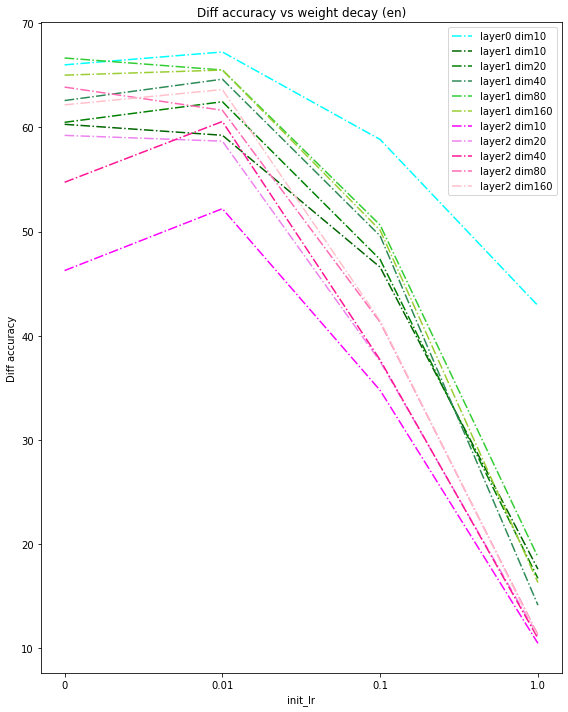

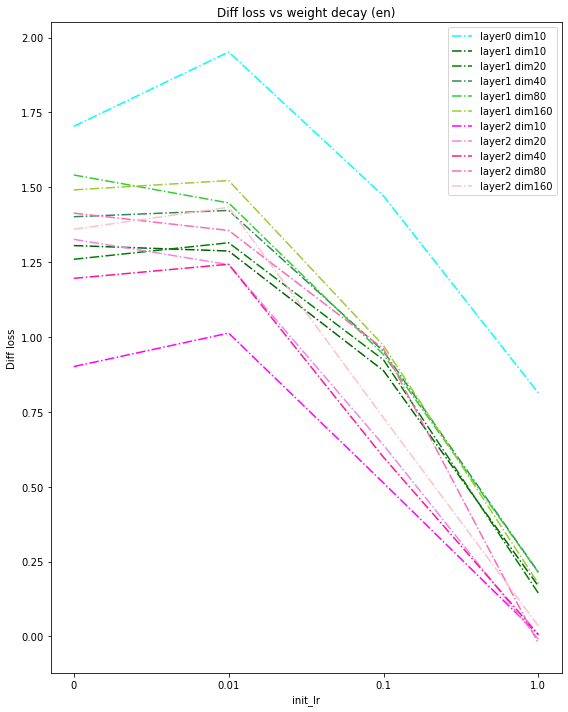

In [48]:
plot_by_config_one_fig(df_with_mean, "hewitt", "en")
plot_by_config_one_fig(df_with_mean, "pimentel", "en")

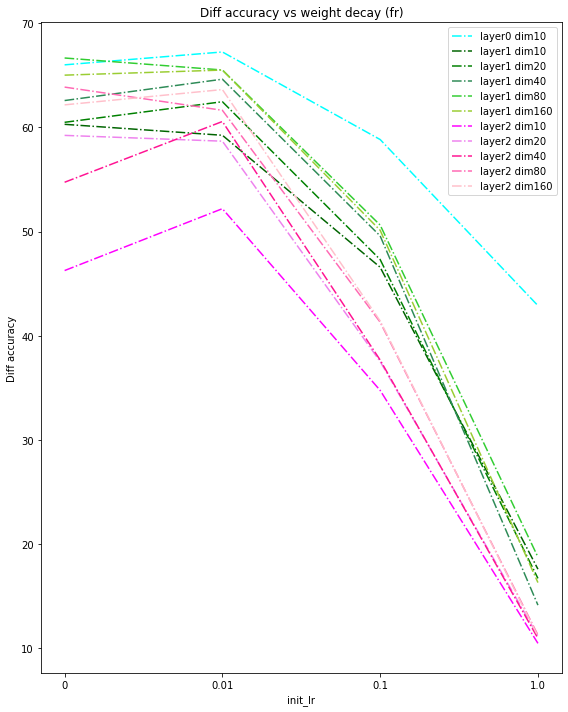

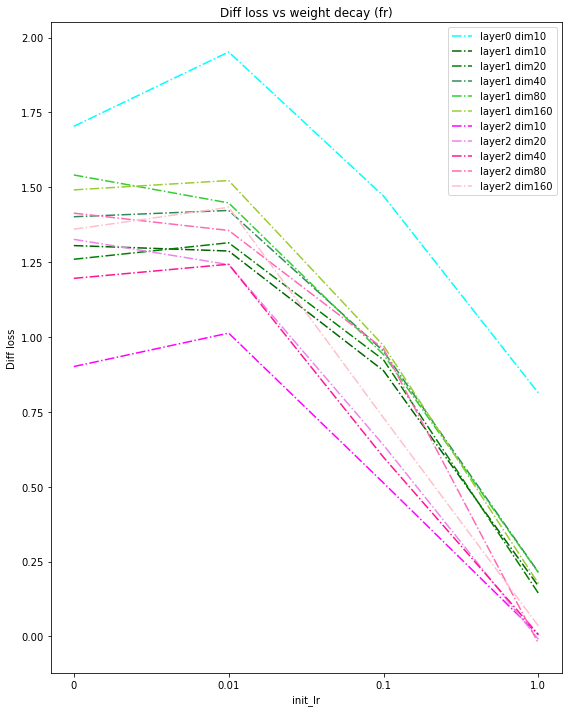

In [49]:
plot_by_config_one_fig(df_with_mean, "hewitt", "fr")
plot_by_config_one_fig(df_with_mean, "pimentel", "fr")

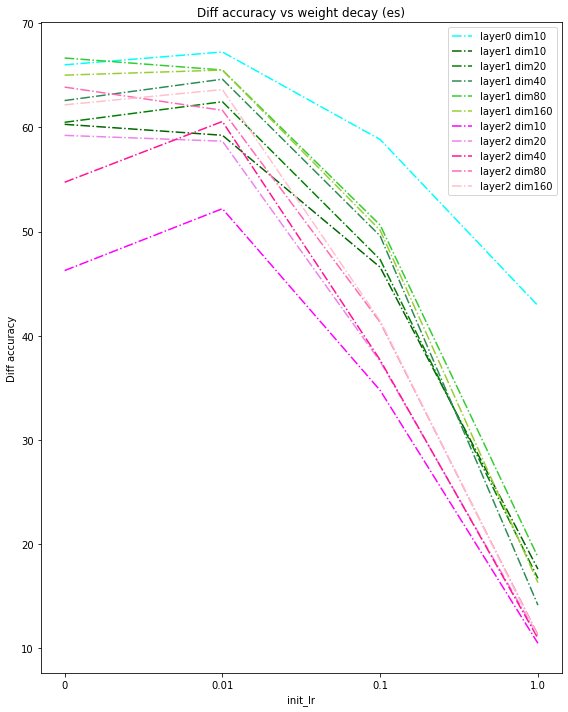

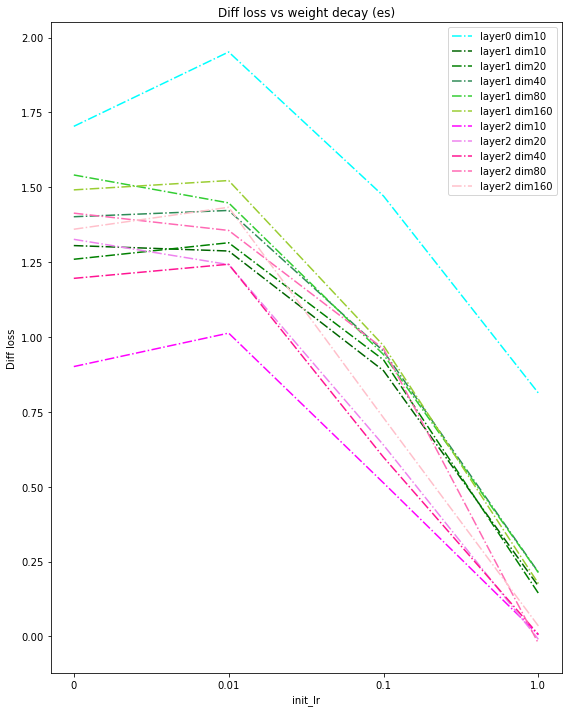

In [50]:
plot_by_config_one_fig(df_with_mean, "hewitt", "es")
plot_by_config_one_fig(df_with_mean, "pimentel", "es")

In [13]:
df_with_mean[(df_with_mean.layer==0)&(df_with_mean.dim==10)&(df_with_mean.task=="crep")&(df_with_mean.weight_decay==0)]

,lang,task,layer,dim,init_lr*1e6,max_grad_step,weight_decay,devloss,testloss,acc
0,en,crep,0,10,1.0,24000,0.0,2.784353,2.782821,12.810787
1,en,crep,0,10,3.0,24000,0.0,2.780802,2.779861,12.752348
5,en,crep,0,10,5.0,24000,0.0,2.792762,2.790417,12.651409
9,en,crep,0,10,10.0,24000,0.0,2.744195,2.741493,9.792171
13,en,crep,0,10,30.0,24000,0.0,2.875861,2.879948,9.941986
17,en,crep,0,10,50.0,24000,0.0,2.912303,2.913824,10.305368
21,en,crep,0,10,100.0,24000,0.0,3.431925,3.444666,8.321646
